# Building a Resource Pack Generator

I'm developing a mod called [FoxNap](https://github.com/OpenBagTwo/FoxNap/) which provides the player with custom musical instruments and music discs. The "killer app" of this mod, besides making all custom items avaialble in survival via villager trades, is that rather than provide a library of music discs, the user can just set the number of music discs to however many they want, and then the mod will dynamically create registrations for that many discs. From there, it's up to the _client_ (read: player) to provide the tracks themselves via a resource pack. Practically what that means is:
- if you're playing single-player, you can add whatever copyrighted music you want to play in your own personal game
- if you're a content creator, you can populate the tracks with your own royalty-free music selections
- if you play on a server, you can populate the tracks with the music that _you_ have the rights to use while your friend populates the tracks with the music that _they_ have the rights to use
- regardless of the situation, you can _swap resource packs_ as the mood strikes, to swap out your music library.

This functionality is there now--the issue is that creating a resource pack from scratch is tedious work, and that's even assuming you've already got everything ready as mono oggs.

So what I'm going to be building out now is a series of steps that will:

1. Convert a mp3, wav, flac or _any_ [`ffmpeg`](https://ffmpeg.org/)-compatible audio format to the correct ogg format
1. Create a custom music disc item texture
1. Populate that disc into a new or existing resource pack, complete with language file entries 

Once I've got the mechanics down, the next step will be creating a cross-platform (I'm gonna have to create a Windows VM 🤢) stand-alone binary (possibly with a _graphical user interface_ 🤮) for distribution with the mod. But that's beyond the scope of this notebook.

## Imports and Setup

In [1]:
# reserved for typing imports

In [2]:
import contextlib
import io
import json
import os
import random
import shutil
import subprocess
from pathlib import Path
from tempfile import NamedTemporaryFile, TemporaryDirectory

import ffmpeg
from IPython.display import Audio, Markdown, display
from PIL import Image

In [3]:
assets_folder = Path("..") / "_static" / "foxnap_rp"

## Converting audio with ffmpeg-python

<div class="alert alert-block alert-warning"><h3>Problem</h3>

Relying on `ffmpeg` is going to make bundling a package for cross-platform distrubution
tricky. For a minute it looked like I'd lucked out and could use `conda`, but the conda
package isn't compiled with libvorbis support, so I'll probably have to bundle
a custom ffmpeg executable with whatever package I distribute.
</div>

The conversion process I've been using thusfar involves calling `ffmpeg` from the command line:

```bash
$ ffmpeg -i some_music.mp3 -c:a libvorbis -ac 1 -map a some_music.ogg
```

and I could just keep doing that directly via `subprocess`. But there's also [this handy wrapper](https://github.com/kkroening/ffmpeg-python) I found for ffmpeg, and letting someone else handle the system calls is much more my jam.

The track I'll be working with is ["Higher" by Tobu](https://www.youtube.com/watch?v=blA7epJJaR4), which:
* slaps
* [is available for free download](https://tobu.io/Higher/download)
* is licensed extremely permissively
* contains album art embedded in the mp3, which I'll talk more about in a sec

But to start, let's load the track.

In [4]:
higher = ffmpeg.input(os.fspath(assets_folder / "Tobu - Higher.mp3"))

Since I'm not doing any filters, this should be pretty straightforward. And what I love about this library is that it gives me a really easy way to preview the command I'm about to run.

In [5]:
print(higher.audio.output("higher.ogg", acodec="libvorbis", ac=1).compile())

['ffmpeg', '-i', '../_static/foxnap_rp/Tobu - Higher.mp3', '-map', '0:a', '-ac', '1', '-acodec', 'libvorbis', 'higher.ogg']


I'm following my nose reading their docs and [examples](https://github.com/kkroening/ffmpeg-python/blob/f3079726fae7b7b71e4175f79c5eeaddc1d205fb/examples/README.md), so I hope this is right, but I guess I'll find out in a second. 

In [6]:
higher.audio.output(
    os.fspath(assets_folder / "higher.ogg"), acodec="libvorbis", ac=1
).overwrite_output().run()

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

(None, None)

That appears to have completed successfully. Let's try something neat:

In [7]:
Audio(assets_folder / "higher.ogg")

Well that was cool!

## Record Texture

I've included two template textures: a regular record and colored vinyl

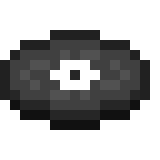

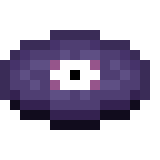

In [8]:
record_template = Image.open(assets_folder / "template_black.png")
colored_vinyl_template = Image.open(assets_folder / "template_colored_vinyl.png")

for image in (record_template, colored_vinyl_template):
    display(image.resize((160, 160), resample=0))

Two elements of customization here:

- The center of each template is transparent, allowing us to layer in a (5x3 lol) custom image from, say, the album art
- The colored vinyl's color can be changed via a simple hue transform.

### Hue Transform

Since we'll want to do the hue transform before performing the overlay, we'll start there.

First step is to convert the image from RGB to HSV:

In [9]:
hsv = colored_vinyl_template.convert("HSV")

From here there might be an efficient high-level method to do the color shift, but we're dealing with a 16x16 image here--we don't really need an extremely performant solution. So let's keep it simple and just loop over the pixels.

In [10]:
accesser = hsv.load()

for i in range(hsv.size[0]):
    for j in range(hsv.size[1]):
        h, s, v = accesser[i, j]
        accesser[i, j] = (int(h + 128) % 360, s, v)

And we'll finish by converting back to RGB and adding in the Alpha channel from the original image.

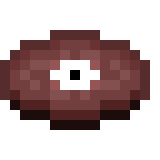

In [11]:
new_template = hsv.convert("RGB")
new_template.putalpha(colored_vinyl_template.getchannel("A"))
display(new_template.resize((160, 160), resample=0))

Nice! Let's generate a bunch of random colored vinyl templates to get a sense for the variance we'll get.

In [12]:
def create_colored_vinyl(
    template: Image.Image | None = None, hue_shift: float | None = None
) -> Image.Image:
    """Create a colored vinyl template
    (record texture with transparency for the center)

    Parameters
    ----------
    template : Image, optional
        The starting template image (RGBA format).
        If None is provided, the template will be loaded from file.
    hue_shift : float, optional
        The degrees to shift the hue. If None is provided,
        the hue will be shifted by a random value.

    Returns
    -------
    Image
        The RGBA image for a colored vinyl template
    """
    if template is None:
        template = Image.open(assets_folder / "template_colored_vinyl.png")
    if hue_shift is None:
        hue_shift = 256.0 * random.random()

    hsv = template.convert("HSV")

    accesser = hsv.load()

    for i in range(hsv.size[0]):
        for j in range(hsv.size[1]):
            h, s, v = accesser[i, j]
            accesser[i, j] = (int(h + hue_shift) % 256, s, v)

    new_template = hsv.convert("RGB")
    new_template.putalpha(template.getchannel("A"))
    return new_template

#### Eight "Uniformally Spaced" Vinyls

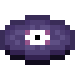

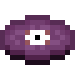

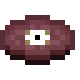

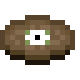

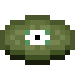

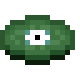

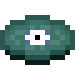

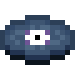

In [13]:
for hue_shift in range(0, 256, 32):
    display(
        create_colored_vinyl(colored_vinyl_template, hue_shift=hue_shift).resize(
            (80, 80), resample=0
        )
    )

Looking good! Let's now try a random sample.

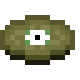

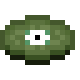

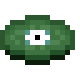

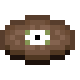

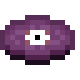

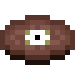

In [14]:
for _ in range(6):
    display(create_colored_vinyl(colored_vinyl_template).resize((80, 80), resample=0))

Okay, so this appears to be working, although I'm sure I'm not using `random.random()` in the best possible way.

### Inlay

As I mentioned at the start, the sample mp3 I grabbed includes album art, which I should be able to extract:

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

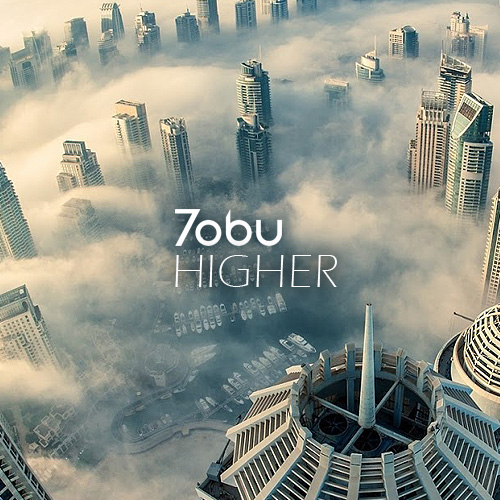

In [15]:
with NamedTemporaryFile(mode="w+b", suffix=".png") as cover:
    higher.video.output(os.fspath(cover.name)).overwrite_output().run()
    display(Image.open(cover.name))

_Heyyy_

Now what if the input music _doesn't have_ album art? We can use the `ogg` we made earlier for testing here, as the album art should have been stripped.

In [16]:
with NamedTemporaryFile(mode="w+b", suffix=".png") as cover:
    ffmpeg.input(os.fspath(assets_folder / "higher.ogg")).video.output(
        os.fspath(cover.name)
    ).overwrite_output().run()
    display(Image.open(cover.name))

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Error: ffmpeg error (see stderr output for detail)

So that just raises a generic exception. But there are three options to pursue (besides a lazy try-except-pass):
1. Inspect the stream in advance to look for a video stream
1. Capture and inspect stderr to look for the exact error mesage
1. Pass in that  "trailing '?'" and see if we can push the error downstream

In [17]:
metadata = ffmpeg.probe(os.fspath(assets_folder / "higher.ogg"))

In [18]:
type(metadata)

dict

In [19]:
metadata.keys()

dict_keys(['streams', 'format'])

In [20]:
type(metadata["streams"])

list

In [21]:
type(metadata["streams"][0])

dict

In [22]:
metadata["streams"][0].keys()

dict_keys(['index', 'codec_name', 'codec_long_name', 'codec_type', 'codec_time_base', 'codec_tag_string', 'codec_tag', 'sample_fmt', 'sample_rate', 'channels', 'channel_layout', 'bits_per_sample', 'r_frame_rate', 'avg_frame_rate', 'time_base', 'start_pts', 'start_time', 'duration_ts', 'duration', 'bit_rate', 'disposition', 'tags'])

In [23]:
metadata["streams"][0]["codec_type"]

'audio'

In [24]:
for stream in metadata["streams"]:
    print(stream["codec_type"])

audio


vs.

In [25]:
metadata = ffmpeg.probe(os.fspath(assets_folder / "Tobu - Higher.mp3"))

for stream in metadata["streams"]:
    print(stream["codec_type"])

audio
video


And thus:

In [26]:
def extract_album_art(track: os.PathLike | str) -> Image.Image | None:
    """Extract the album art from an audio track, if the track
    has album art encoded.

    Parameters
    ----------
    track: pathlike
        path to the track

    Returns
    -------
    Image or None
        the album art embedded in the audio track, or None if the
        track did't have any album art embedded
    """

    track_path = os.fspath(track)
    metadata = ffmpeg.probe(track_path)
    if "video" not in (stream["codec_type"] for stream in metadata["streams"]):
        return None
    with NamedTemporaryFile(mode="w+b", suffix=".png") as cover:
        ffmpeg.input(track_path).video.output(
            os.fspath(cover.name)
        ).overwrite_output().run()

        # move it to in-memory buffer so tempfile can be deleted
        album_art = Image.open(cover.name)
        buffer = io.BytesIO()
        album_art.save(buffer, format="png")

        return Image.open(buffer)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

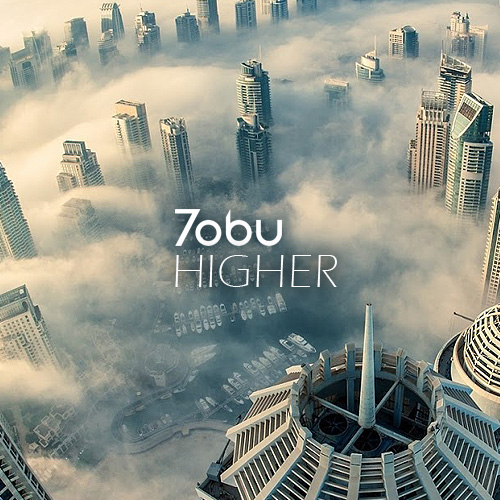

In [27]:
display(extract_album_art(assets_folder / "Tobu - Higher.mp3"))

vs.

In [28]:
display(extract_album_art(assets_folder / "higher.ogg"))

None

Now for the real image, we're obviously not going to be able to put the entire art in a 5x3 inlay, so let's (hilariously) downsample it.

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

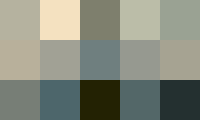

In [29]:
art = extract_album_art(assets_folder / "Tobu - Higher.mp3")
display(art.resize((5, 3), resample=0).resize((200, 120), resample=0))  # type: ignore

In the event the track has no art, let's just create a random image.

In [30]:
def generate_random_inlay() -> Image.Image:
    """Generate a random 5x3 image

    Parameters
    ----------
    None

    Returns
    -------
    Image
        A random 5x3 image that can
        be used as an inlay
    """
    inlay = Image.new("HSV", (5, 3))
    accesser = inlay.load()

    for i in range(inlay.size[0]):
        for j in range(inlay.size[1]):
            # max saturation and brightness, random hue
            accesser[i, j] = (random.randint(0, 255), 255, 255)

    return inlay.convert("RGB")

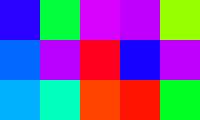

In [31]:
display(generate_random_inlay().resize((200, 120), resample=0))

All right!

And finally we composite:

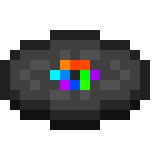

In [32]:
record = Image.new("RGBA", (16, 16))
record.paste(generate_random_inlay(), (5, 6))
record.paste(record_template, (0, 0), mask=record_template)
display(record.resize((160, 160), resample=0))

Nice! Or with the colored vinyl:

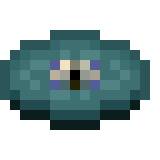

In [33]:
record = Image.new("RGBA", (16, 16))
record.paste(cover.resize((5, 3), resample=0), (5, 6))
record.paste(create_colored_vinyl(), (0, 0), mask=record_template)
display(record.resize((160, 160), resample=0))

I love it.

## Resourcepack Generation

Now we just need to build a resourcepack around these assets.

### JSONs

In [34]:
mcmeta = {
    "pack": {
        "pack_format": 10,
        "description": [
            {"text": "Custom FoxNap Records", "color": "gold"},
            {"text": "\nGenerated with Magic", "color": "aqua"},
        ],
    }
}

In [35]:
def generate_sound_registry(*track_numbers: int) -> dict:
    """Generate the sound registry for all new tracks

    Parameters
    ----------
    *track_numbers : ints
        The numbers of the tracks to generate. Need not
        be sequential if, for example, we're overwriting
        one of the default tracks

    Returns
    -------
    dict
        The sound registry, all set to be written as json
    """
    sounds = {}
    for track in track_numbers:
        sounds[f"track_{track}"] = {"category": "record", "sounds": [f"record_{track}"]}
    return sounds

In [36]:
# Test
generate_sound_registry(8)

{'track_8': {'category': 'record', 'sounds': ['record_8']}}

In [37]:
def generate_model(track_number: int) -> dict:
    """Generate a model JSON for a new record

    Parameters
    ----------
    track_number : int
        The number of the track to generate

    Returns
    -------
    dict
        The model info, all set to be written as JSON
    """
    return {
        "parent": "minecraft:item/generated",
        "textures": {"layer0": f"record_{track_number}"},
    }

In [38]:
# Test
generate_model(8)

{'parent': 'minecraft:item/generated', 'textures': {'layer0': 'record_8'}}

### Track Names

The last JSON we need is the language file, which needs to contain the actual track name. Which, again, we're going to extract from the track metadata (if we can).

In [39]:
metadata = ffmpeg.probe(os.fspath(assets_folder / "Tobu - Higher.mp3"))

In [40]:
metadata["format"].keys()

dict_keys(['filename', 'nb_streams', 'nb_programs', 'format_name', 'format_long_name', 'start_time', 'duration', 'size', 'bit_rate', 'probe_score', 'tags'])

In [41]:
metadata["format"]["tags"]

{'TBPM': '130',
 'genre': 'Progressive House',
 'title': 'Higher',
 'artist': 'Tobu',
 'comment': '',
 'composer': 'Tobu',
 'date': '2013'}

Okay, so we're just gonna need to do some case logic.

In [42]:
def extract_track_description(track: os.PathLike | str) -> str:
    """Extract a description from an audio track, if the track
    has metadata encoded

    Parameters
    ----------
    track: pathlike
        path to the track

    Returns
    -------
    str
        A description of the track (comprising title, artist, composer, etc.)
        if such information was encoded, or just the filename otherwise.
    """
    metadata = ffmpeg.probe(os.fspath(track))
    track_info = metadata.get("format", {}).get("tags", {})
    title = track_info.get("title")
    artist = track_info.get("artist")
    composer = track_info.get("composer")

    if title is None:
        return Path(track).name

    if artist is None and composer is None:
        return title

    if artist == composer or composer is None:
        return f"{artist} - {title}"

    if artist is None:
        return f"{composer} - {title}"

    return f"{artist} - {title} ({composer})"

In [43]:
# Test
print(extract_track_description(assets_folder / "Tobu - Higher.mp3"))
print(extract_track_description(assets_folder / "higher.ogg"))

Tobu - Higher
higher.ogg


Nice!

In [44]:
def generate_lang_file(*tracks: tuple[int, os.PathLike | str]) -> dict[str, str]:
    """Generate the lanuage file for all new tracks

    Parameters
    ----------
    *tracks : (int, pathlike) tuples
        The numbers and paths to the racks to generate. Need not
        be sequential if, for example, we're overwriting
        one of the default tracks

    Returns
    -------
    dict
        The language file, all set to be written as json
    """
    lang: dict[str, str] = {}
    for track in tracks:
        track_num, track_path = track
        lang[f"item.foxnap.track_{track_num}"] = "Music Disc"
        lang[f"item.foxnap.track_{track_num}.desc"] = extract_track_description(
            track_path
        )
    return lang

In [45]:
# Test
generate_lang_file(
    (8, assets_folder / "Tobu - Higher.mp3"), (9, assets_folder / "higher.ogg")
)

{'item.foxnap.track_8': 'Music Disc',
 'item.foxnap.track_8.desc': 'Tobu - Higher',
 'item.foxnap.track_9': 'Music Disc',
 'item.foxnap.track_9.desc': 'higher.ogg'}

### Put it All Together

In [46]:
def generate_resourcepack(
    output_path: os.PathLike | str, *tracks: tuple[int, os.PathLike | str, bool]
) -> None:
    """Generate a FoxNap resource pack!

    Parameters
    ----------
    output_path : pathlike
        The filename of the resourcepack (omit the ".zip" extension)
    *tracks : (int, pathlike, bool) tuples
        The tracks to generate in the following format:
        - int : the number of the track (need not be sequential, can overwrite
                one of the default tracks)
        - pathlike : the path to the music track to include
        - bool : if True, make the item texture a colored vinyl.

    Returns
    -------
    None
    """
    with TemporaryDirectory() as tmpdir:
        root = Path(tmpdir)

        with (root / "pack.mcmeta").open("w") as f:
            json.dump(mcmeta, f)
        shutil.copy(assets_folder / "icon.png", root / "icon.png")

        foxnap_root = root / "assets" / "foxnap"
        foxnap_root.mkdir(parents=True, exist_ok=True)

        sounds = foxnap_root / "sounds"
        sounds.mkdir(exist_ok=True)
        for track_num, track_path, _ in tracks:
            ffmpeg.input(os.fspath(track_path)).audio.output(
                os.fspath(sounds / f"track_{track_num}.ogg"), acodec="libvorbis", ac=1
            ).overwrite_output().run()

        with (foxnap_root / "sounds.json").open("w") as f:
            json.dump(generate_sound_registry(*(track[0] for track in tracks)), f)

        models = foxnap_root / "models" / "item"
        models.mkdir(parents=True, exist_ok=True)
        for track_num, _, _ in tracks:
            with (models / f"track_{track_num}.json").open("w") as f:
                json.dump(generate_model(track_num), f)

        textures = foxnap_root / "textures"
        textures.mkdir(exist_ok=True)
        for track_num, track_path, colored_vinyl in tracks:
            inlay = extract_album_art(track_path)
            if inlay is None:
                inlay = generate_random_inlay()
            else:
                inlay = inlay.resize((5, 3), resample=0)
            if colored_vinyl:
                template = create_colored_vinyl(colored_vinyl_template)
            else:
                template = record_template
            record = Image.new("RGBA", (16, 16))
            record.paste(inlay, (5, 6))
            record.paste(template, (0, 0), mask=template)
            with (textures / f"record_{track_num}.png").open("wb") as f:
                record.save(f, format="png")

        lang = foxnap_root / "lang"
        lang.mkdir(exist_ok=True)
        with (lang / "en_us.json").open("w") as f:
            json.dump(
                generate_lang_file(*((track[0], track[1]) for track in tracks)), f
            )

        shutil.make_archive(str(output_path), "zip", root)

In [47]:
generate_resourcepack(
    assets_folder / "foo", (8, assets_folder / "Tobu - Higher.mp3", True)
)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Did it work? Well, [see for yourself.](../_static/foxnap_rp/foo.zip)